In [1]:
# Add the genderComputer library to the path
import os
import sys

path = os.path.join(os.getcwd(), 'vendor', 'genderComputer')
sys.path.insert(0, path)

In [2]:
# Infer the gender of the authors
import analyze_genders

df = analyze_genders.dataframe()
df.loc[df.conf == 'vldb', 'conf'] = 'vldb/pvldb'

# Find the index of the last author of each paper and add to the original data frame
last_author_index = df.groupby(['paper_id'], sort=False)['author_position'].max().to_frame()
first_paper = df.groupby(['author_id'], sort=False)['year'].min().to_frame()
df = df.join(last_author_index, on='paper_id', rsuffix='_last')
df = df.join(first_paper, on='author_id', rsuffix='_first_paper').sort_values(['paper_id', 'author_position'])

In [3]:
def first_female_author(group):
    return group['female'].iloc[0]

def last_female_author(group):
    return group['female'].iloc[group['author_position_last'].iloc[0]]

def any_female_author(group):
    return group['female'].any()

def all_female_author(group):
    return group['female'].all()

df_first = df.groupby(['paper_id', 'conf', 'year'], sort=False).apply(first_female_author).to_frame('female')
df_last = df.groupby(['paper_id', 'conf', 'year'], sort=False).apply(last_female_author).to_frame('female')
df_any = df.groupby(['paper_id', 'conf', 'year'], sort=False).apply(any_female_author).to_frame('female')
df_all = df.groupby(['paper_id', 'conf', 'year'], sort=False).apply(all_female_author).to_frame('female')

In [4]:
first_ratio = df_first.groupby(['conf', 'year']).mean().multiply(100)
last_ratio = df_last.groupby(['conf', 'year']).mean().multiply(100)
any_ratio = df_any.groupby(['conf', 'year']).mean().multiply(100)
all_ratio = df_all.groupby(['conf', 'year']).mean().multiply(100)

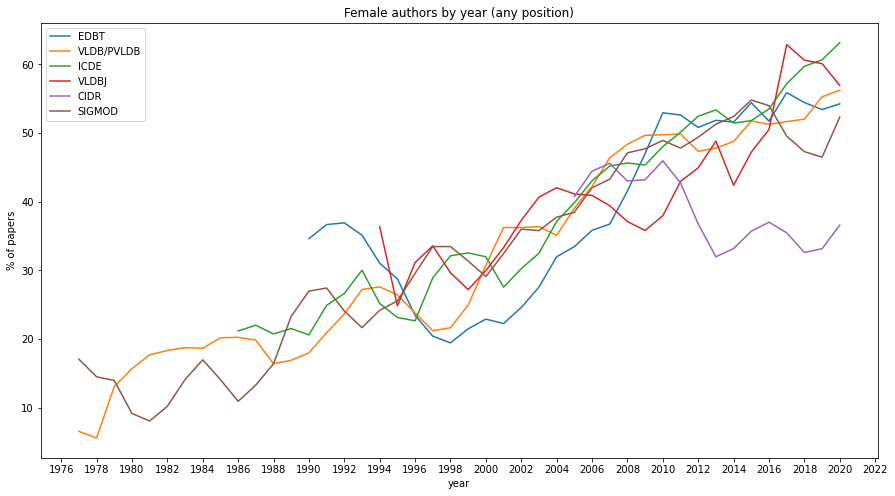

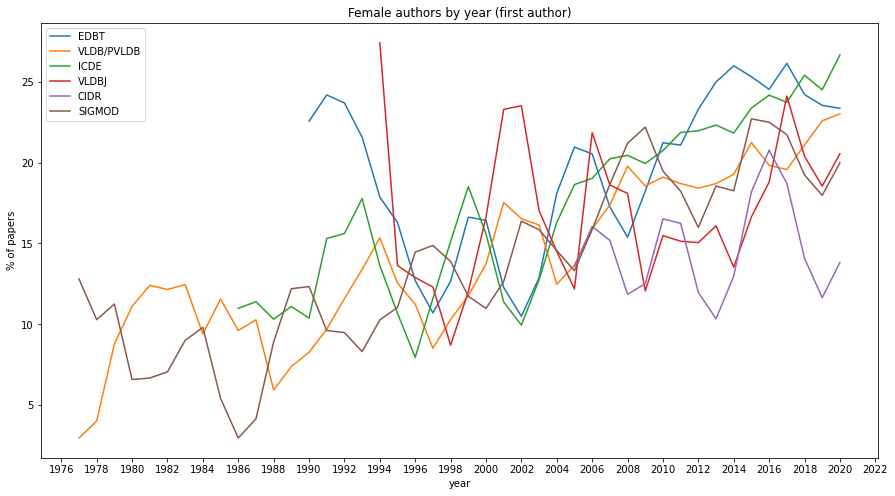

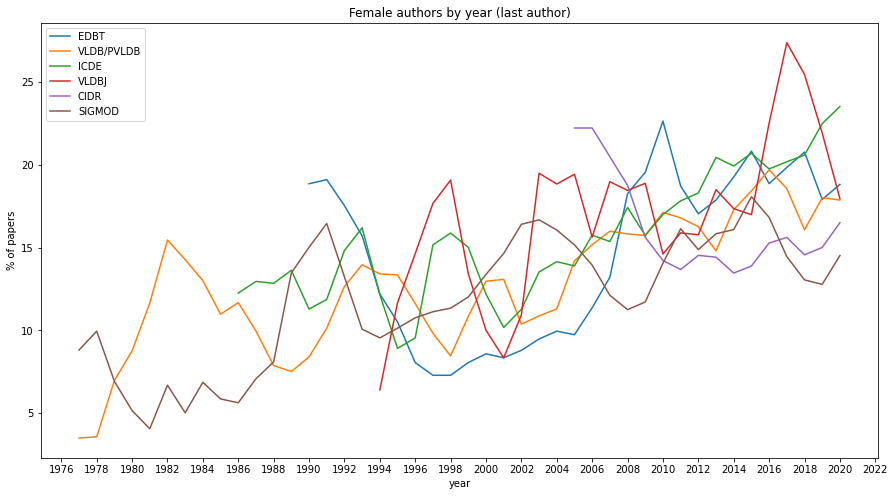

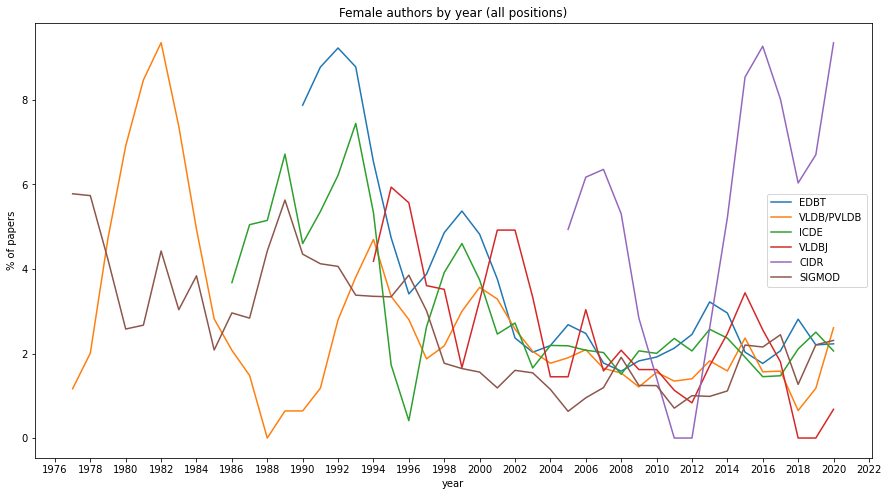

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_authors(df, plot_type):
    fig = df.unstack(level=0).sort_values(['year']).ffill().rolling(window=3).mean().plot(figsize=(15,8), title='Female authors by year (%s)' % plot_type)
    fig.xaxis.set_major_locator(ticker.MultipleLocator(2))
    fig.set_ylabel('% of papers')
    fig.legend([c.split(', ')[1].rstrip(')').upper() for c in fig.get_legend_handles_labels()[1]])

plot_authors(any_ratio, 'any position')
plot_authors(first_ratio, 'first author')
plot_authors(last_ratio, 'last author')
plot_authors(all_ratio, 'all positions')